# Notes

This script replicates the Fama French 5 (2x2) risk factors SMB, HML, RMW, and CMA, in addition to the excess market risk factor, and augments the factor set with a candidate factor based on measures pass by the user in a file or a a list of files. The data come from CRSP for pricing related items and Compustat for fundamental data. The data are accessed through WRDS.

This script has been adapted from the Fama French 3 factors script posted on WRDS, written by Qingyi (Freda) Song Drechsler in April 2018 and updated in June 2020.<br>(https://wrds-www.wharton.upenn.edu/pages/support/applications/python-replications/fama-french-factors-python/<br>https://www.fredasongdrechsler.com/full-python-code/fama-french)"

Research notes:

- only ordinary common stocks (CRSP sharecode 10 and 11) in NYSE, AMEX and NASDAQ (exchange code 1,2,3) and at least 2 years on Compustat are included in the sample (Fama and French (1993, 2015); https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/).
- all the breakpoints are computed only on NYSE stocks (from the sample).
- market cap is calculated at issue-level (permno in CRSP), and book value of equity is calculated at company level (permco in Compustat), it is needed to aggregate market cap at company level (permco in CRSP) for later book-to-market value calculation. And market cap of companies at December of year t-1 is used for portfolio formation at June of year t. Details on how to link CRSP and Compustat:<br>
    https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/crsp/crspcompustat-merged-ccm/wrds-overview-crspcompustat-merged-ccm/<br>https://wrds-www.wharton.upenn.edu/pages/support/applications/linking-databases/linking-crsp-and-compustat/
- there were cases when the same firm (CRSP permco) had two or more securities (CRSP permno) on the same date. For the purpose of ME for the firm, I aggregated all ME for a given CRSP permco, date. This aggregated ME was assigned to the CRSP permno according to the following criteria largest market equity (ME), higher number of years on Compustat (count) (as recommended by WRDS (https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/) and finally random, in this order. If the ME and years on Compustat are the same there is no other unbiased criteria but random (one would select the one with either largest or smallest return). However these cases are less than 100. The ME to assign to the permco is the sum of the ME of all the permno of that permco.
- the relevant share code for Fama French factors constructions are 10 and 11 (ordinary common stocks). The permno for the same permco may have different share code (shrcd), filtering them before applying the logic o the previous point would end up in loosing market capitalization. The solution is to delete later, when each permco has only one permno, all the permno with shrcd different from 10 or 11.
- I merged CRSP and Compustat using the CRSP CCM product (as of April 2010) as recommended by WRDS (https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/) matching Compustat's gvkey (from calendar year t-1) to CRSP's permno as of June year t. Data was cleaned for unnecessary duplicates. First there were cases when different gvkeys exist for same permno-date. I solved these duplicates by only keeping those cases that are flagged as 'primary' matches by CRSP's CCM (linkprim='P'). There were other unnecessary duplicates that were removed (I kept the oldest gvkey for each permno, finally I randomly picked one gvkey for each of of the about 30 pairs od dupliated permno which were practically identical if not for fractions of decimals differences on certain measures). Some companies on Compustat may have two annual accounting records in the same calendar year. This is produced by change in the fiscal year end during the same calendar year. In these cases, we selected the last annual record for a given calendar year.

Variable definitions (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/variable_definitions.html)

- ME: Market Equity. Market equity (size) is price times shares outstanding. Price is from CRSP, shares outstanding are from Compustat (if available) or CRSP.

- BE: Equity. Book equity is constructed from Compustat data or collected from the Moody’s Industrial, Financial, and Utilities manuals. BE is the book value of stockholders’ equity, plus balance sheet deferred taxes and investment tax credit (if available), minus the book value of preferred stock. Depending on availability, we use the redemption, liquidation, or par value (in that order) to estimate the book value of preferred stock. Stockholders’ equity is the value reported by Moody’s or Compustat, if it is available. If not, we measure stockholders’ equity as the book value of common equity plus the par value of preferred stock, or the book value of assets minus total liabilities (in that order). See Davis, Fama, and French, 2000, “Characteristics, Covariances, and Average Returns: 1929-1997,” Journal of Finance, for more details.

- BE/ME: Book-to-Market. The book-to-market ratio used to form portfolios in June of year t is book equity for the fiscal year ending in calendar year t-1, divided by market equity at the end of December of t-1.
 
- OP: Operating Profitability. The operating profitability ratio used to form portfolios in June of year t is annual revenues minus cost of goods sold, interest expense, and selling, general, and administrative expense divided by the sum of book equity and minority interest for the last fiscal year ending in t-1.
 
- INV: Investment. The investment ratio used to form portfolios in June of year t is the change in total assets from the fiscal year ending in year t-2 to the fiscal year ending in t-1, divided by t-2 total assets.

Techincal notes:

- In order to tun the script one has to connect ot the WRDS databases and have a valid WRDS account. Here are the details on how to set up a connection or run the scrip on the WRDS cloud.<br>https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-wrds-cloud/<br>https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-from-your-computer/
- WRDS Python library documentation
https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/querying-wrds-data-python/

User guide:

- Basic
    - the user has to place one or more measures file (.csv) in the path assigned to the variable nf_measures_path
    - each measure file can contain multiple measures on the columns (with headers)
    - each measure file contains on the rows pairs of "jdate" (dates of last day of June in format YYYY-MM-DD) and "permno" (containing Compustat PERMNO). The first two columns in the csv file must be called "permno and "date"
    - for each measure file passed, the corresponding factors (and additional file for firms count) are saved in a csv file with a similar name, the rows are oranized for date, measure for which robust breakpoints have been choosed, the breakpoints percentailes, measure name

- Advanced
    - in the Fama French 5 factors procedure the factors are constructed using as breakpoints 30th and 70th percentiles for B/M, OP, and INV
    - here the user can specify in the list variable measures_robust_check_bp all the factors for which he or she wants to use alternative breakpoint percentiles (for instance measures_robust_check_bp=['bm', 'inv', 'op', 'nf'] if alternative breakpoints want ot be used for all the factors)
    - the alernative breakpoints are fixed to be 10th and 90th, 20th and 80th, 30th and 70th, 40th and 60th.

Descriptions of Fama French 5 factors (2x3) can be found on Kenneth French's website.<br>http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html <br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html"

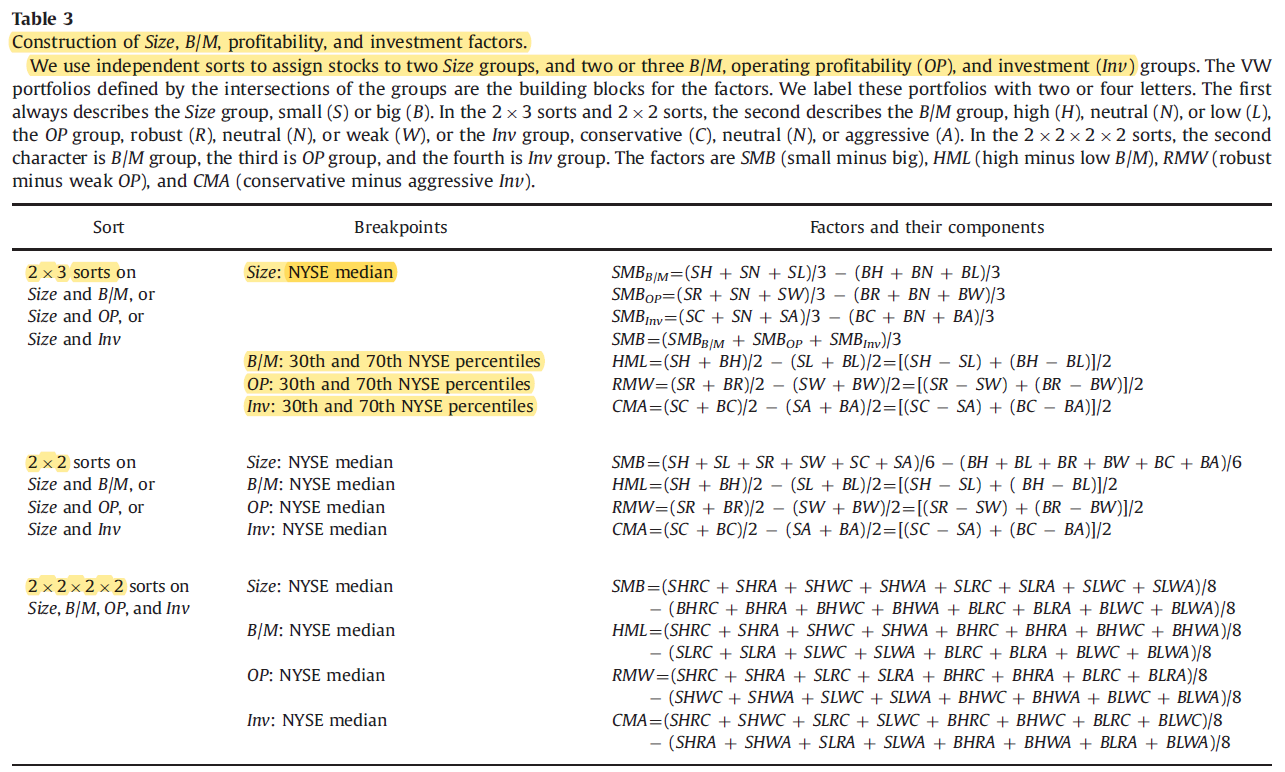

References:
- Fama, Eugene F. and Kenneth R. French, 1993, Common Risk Factors in Stocks and Bonds, Journal of Financial Economics, 33, 3-56.
- Fama, E.F. and French, K.R., 2015. A five-factor asset pricing model. Journal of financial economics, 116(1), pp.1-22.

# Script

In [12]:
# list of all measures for which a factor will be computed
all_measures=['bm','inv','op','nf']
# measures for which all the breakpoints (10_90, 20_80, 30_70, 40_60) subsets are used instead of the default 30_70
# measures_robust_check_bp=['bm', 'inv', 'op', 'nf']
measures_robust_check_bp=[]

In [13]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt
import urllib
import zipfile
from scipy import stats
import glob
from tqdm import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

#set to 1 to delete intermediate datasets
save_memory=0

#set to 1 to print more check outputs
print_advance_output=0

## Functions

In [14]:
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

## Computation

In [15]:
project_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\"
factors_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\factors\\"
test_assets_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\test_assets\\"
ff5measures_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\FF5 measures\\"
nf_measures_path="G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\"

Read the CRSP table with stock returns produced by FF5_measures_computer_and_FF5_factors_replicator\FF5_measures_computer_and_FF5_factors_replicator.ipynb

In [16]:
crsp3=pd.read_csv(ff5measures_path+'crsp_returns.csv', sep=',')
crsp3['jdate']=pd.to_datetime(crsp3['jdate'])
# crsp3.set_index(['permno','jdate'], inplace=True)
crsp3

,permno,date,jdate,ffyear,retadj,wt
0,10000,1986-07-31,1986-07-31,1986,-0.080808,1.173459e+04
1,10000,1986-08-29,1986-08-31,1986,-0.615385,1.078634e+04
2,10000,1986-09-30,1986-09-30,1986,-0.057143,4.148594e+03
3,10000,1986-10-31,1986-10-31,1986,-0.242424,3.911531e+03
4,10000,1986-11-28,1986-11-30,1986,0.060000,2.963281e+03
...,...,...,...,...,...,...
3068885,93436,2020-08-31,2020-08-31,2020,0.741452,2.661214e+08
3068886,93436,2020-09-30,2020-09-30,2020,-0.139087,4.634376e+08
3068887,93436,2020-10-30,2020-10-31,2020,-0.095499,3.989793e+08
3068888,93436,2020-11-30,2020-11-30,2020,0.462736,3.608772e+08


Read the original FF5 data

In [17]:
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
urllib.request.urlretrieve(ff_url,'F-F_Research_Data_5_Factors_2x3_CSV.zip ')
zip_file = zipfile.ZipFile('F-F_Research_Data_5_Factors_2x3_CSV.zip', 'r')
zip_file.extractall()
zip_file.close()
ff_factors_original = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows = 3)
ff_factors_original = ff_factors_original[0:ff_factors_original.isnull().any(axis=1).idxmax()].rename(columns={'Unnamed: 0':'date'}).set_index('date').astype(float).div(100)
ff_factors_original.index = pd.to_datetime(ff_factors_original.index, format='%Y%m')+MonthEnd(0)
ff_factors_original=ff_factors_original[ff_factors_original.index<=crsp3['date'].max()]
ff_factors_original

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-31,-0.0039,-0.0045,-0.0094,0.0066,-0.0115,0.0027
1963-08-31,0.0507,-0.0082,0.0182,0.0040,-0.0040,0.0025
1963-09-30,-0.0157,-0.0048,0.0017,-0.0076,0.0024,0.0027
1963-10-31,0.0253,-0.0130,-0.0004,0.0275,-0.0224,0.0029
1963-11-30,-0.0085,-0.0085,0.0170,-0.0045,0.0222,0.0027
...,...,...,...,...,...,...
2020-08-31,0.0763,-0.0094,-0.0294,0.0427,-0.0144,0.0001
2020-09-30,-0.0363,0.0007,-0.0251,-0.0115,-0.0177,0.0001
2020-10-31,-0.0210,0.0476,0.0403,-0.0060,-0.0053,0.0001


Reading FF5 measures

In [18]:
ff5_measures=pd.read_csv(ff5measures_path+'FF5_measures.csv', sep=',')
ff5_measures['jdate']=pd.to_datetime(ff5_measures['jdate'])
# ff5_measures.set_index(['permno','jdate'], inplace=True)/
#in order to keep using part of the scritp "FF5_measures_computer_and_FF5_factors_replicator" the info in ff5_measures
#can be used instea of the original ccm_jun. A copy is done to avoid changing variable names later
ccm_jun=ff5_measures.copy()
if save_memory:
    del ff5_measures
ccm_jun

,permno,jdate,me,beme,inv,op,is_size_ok,is_beme_ok,is_inv_ok,is_op_ok,shrcd,dec_me,be,mib,revt,xsga,xint,cogs,exchcd,prc,shrout
0,10001,1988-06-30,6.200000e+03,1.207618,NaN,0.110827,1,1,0,1,11,5.828000e+03,7.038,0.000,16.621,NaN,0.303,15.538,3,6.250000,992.0
1,10001,1989-06-30,7.007000e+03,1.145192,-0.003058,0.152484,1,1,1,1,11,6.362250e+03,7.286,0.000,16.978,NaN,0.311,15.556,3,7.000000,1001.0
2,10001,1990-06-30,1.005225e+04,0.818149,0.582020,0.283841,1,1,1,1,11,1.034775e+04,8.466,0.000,22.910,NaN,0.651,19.856,3,9.750000,1031.0
3,10001,1991-06-30,1.126650e+04,0.942575,0.017021,0.263297,1,1,1,1,11,1.001300e+04,9.438,0.000,23.227,NaN,0.835,19.907,3,10.500000,1073.0
4,10001,1992-06-30,1.263125e+04,0.667907,0.038028,0.229853,1,1,1,1,11,1.558750e+04,10.411,0.000,23.850,NaN,0.775,20.682,3,11.750000,1075.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223277,93436,2016-06-30,3.142062e+07,0.035855,0.383504,-0.401743,1,1,1,1,11,3.154331e+07,1130.989,0.000,4046.025,1640.132,160.328,2699.932,3,212.279999,148015.0
223278,93436,2017-06-30,6.033933e+07,0.137924,1.800641,0.010911,1,1,1,1,11,3.452397e+07,4761.695,367.039,7000.132,2244.897,245.501,4453.776,3,361.609985,166863.0
223279,93436,2018-06-30,5.847846e+07,0.080626,0.264352,-0.113322,1,1,1,1,11,5.255495e+07,4237.312,397.734,11758.751,3787.573,596.172,7900.261,3,342.950012,170516.0
223280,93436,2019-06-30,4.002571e+07,0.085708,0.037837,0.167355,1,1,1,1,11,5.744194e+07,4923.243,555.964,21461.268,4294.861,717.971,15531.461,3,223.460007,179118.0


Clone ccm_jun and crsp3 to preserve the original and recall them at every new computation without reloading them

In [19]:
ccm_jun_original=ccm_jun.drop(columns=ccm_jun.columns[ccm_jun.columns.str.contains('_ok')], axis=0).copy() #dropped the is_.._ok columns
crsp3_original=crsp3.copy()

Reading the new factor measures files

In [20]:
nf_measures_files=glob.glob(nf_measures_path+"*.csv")
nf_measures_files

['G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v1.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v2.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v3.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v1.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v2.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v3.csv',
 'G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\measures\\measures_196306_202006_FFmkt_S=[1  0]_exc_stat

In [21]:
print('##################################################################################################################')
print('##################################################################################################################')
print('### START LOOP ON MEASURES FILES')
print('##################################################################################################################')
print('##################################################################################################################')

# for f in tqdm([nf_measures_files[0]], desc='measures_files_loop'): #DEBUG: SLICING LIST OF MEASURES FILES
for f in tqdm(nf_measures_files, desc='measures_files_loop'): 

    ff_factors_final2export=pd.DataFrame()
    ff_nfirms_final2export=pd.DataFrame()
    
    #read the file
    print('#####################################################################################')
    print("reading file {}".format(f.split('\\')[-1]))
    pd.read_csv(f)
    nf_measures=pd.read_csv(f)
    nf_measures.rename(columns={'date':'jdate'}, inplace=True)
    nf_measures['jdate']=pd.to_datetime(nf_measures['jdate'], format="%Y%m")+MonthEnd(0)    
    nf_measures=pd.merge(ccm_jun_original.loc[:,['permno','jdate']], nf_measures, how='inner', on=['permno','jdate'])
    nf_measures.set_index(['jdate','permno'], inplace=True)

    print('#####################################################################################')
    print('min, max and mean number of stocks with good measure, over periods, for each measure')    
    print(nf_measures.notna().groupby('jdate').sum().agg(['min', 'max', 'mean']).T.astype(int))

    #filter the pairs of stocks and june dates not in common betweeen FF5 measures and New Factor measures
    ccm_jun=pd.merge(ccm_jun_original, nf_measures, how='inner', left_on=['jdate','permno'], right_index=True).loc[:,ccm_jun_original.columns.to_list()]
    print('#####################################################################################')
    print("{} pairs of stocks and june dates in common betweeen FF5 and New Factor".format(ccm_jun.shape[0]))

   # at this point shrcd different from 10 and 11, not valid price and shares and company with less than 2 years of
    # history on Compustat have been removed, even though their conditions are explicitly present here

    # size breakdown
    nyse_sz=ccm_jun[(ccm_jun['exchcd']==1)&
            ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&
            (~ccm_jun['prc'].isna())&
            (~ccm_jun['shrout'].isna())].groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})
    nyse_breaks=pd.merge(pd.DataFrame([d-relativedelta(months=1) for d in ff_factors_original.index if d.month==7]).set_index(0), nyse_sz, how='left', left_index=True, right_on='jdate')

    # bp breakpoints
    nyse_bm=ccm_jun[(ccm_jun['exchcd']==1)&
            ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&
            (~ccm_jun['dec_me'].isna())&
            (ccm_jun['be']>0)].groupby(['jdate'])['beme'].median().to_frame().reset_index().rename(columns={'beme':'bm50'})

    # inv breakdown
    nyse_inv=ccm_jun[(ccm_jun['exchcd']==1)&
            ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&                 
            (~ccm_jun['inv'].isna())].groupby(['jdate'])['inv'].median().to_frame().reset_index().rename(columns={'inv':'inv50'})

    # op breakdown
    nyse_op=ccm_jun[(ccm_jun['exchcd']==1)&
            ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&  
            (ccm_jun['be']>0)&                               
            (~ccm_jun['revt'].isna())&
            (~ccm_jun.loc[:,['cogs','xsga','xint']].isna().all(axis=1))].groupby(['jdate'])['op'].median().to_frame().reset_index().rename(columns={'op':'op50'})

    #join back size, beme and inv breakdown
    nyse_breaks = pd.merge(nyse_breaks,pd.merge(pd.merge(nyse_bm, nyse_inv, how='outer', on=['jdate']), nyse_op, how='outer', on=['jdate']), how='left', on=['jdate'])

    # allign breakpoints to variables
    ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])
    ccm1_jun['ffyear']=ccm1_jun['jdate'].dt.year


    # Adding flag to the stocks with good FF5 measures

    ccm1_jun.loc[:,'is_size_ok']=np.where((ccm1_jun['me']>0)&
                                          ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))
                                          ,1,0)

    ccm1_jun.loc[:,'is_beme_ok']=np.where((ccm1_jun['be']>0)&
                                          (ccm1_jun['dec_me'].notna())&
                                          ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                          (ccm1_jun['me']>0),1,0)

    ccm1_jun.loc[:,'is_inv_ok']=np.where((ccm1_jun['inv'].notna())&
                                         ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                         (ccm1_jun['me']>0),1,0)

    ccm1_jun.loc[:,'is_op_ok']=np.where(((ccm1_jun['be'])>0)&(ccm1_jun['revt'].notna())&
                                        (ccm1_jun.loc[:,['xsga','xint','cogs']].notna().any(axis=1))&
                                        ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                        (ccm1_jun['me']>0),1,0)
    

    # Assign portfolios for FF5 measures

    print('#####################################################################################')     
    # assign size portfolios
    print('size breakpoints 50_50')
    ccm1_jun['szport']=np.where((ccm1_jun['is_size_ok']==1), 
                                np.where(ccm1_jun['me']<=ccm1_jun['sizemedn'], 'S', 
                                         np.where(ccm1_jun['me']>ccm1_jun['sizemedn'], 'B',
                                                  np.nan))
                                , np.nan)
        
    # assign book-to-market portfolios 
    print('beme breakpoints 50_50')
    ccm1_jun['bmport']=np.where((ccm1_jun['is_beme_ok']==1), 
                                np.where(ccm1_jun['beme']<=ccm1_jun['bm50'], 'L', 
                                         np.where(ccm1_jun['beme']>ccm1_jun['bm50'], 'H',
                                                  np.nan))
                                , np.nan)  
    
    # assign operating profitability portfolios
    print('op breakpoints 50_50')
    ccm1_jun['opport']=np.where((ccm1_jun['is_op_ok']==1), 
                                np.where(ccm1_jun['op']<=ccm1_jun['op50'], 'W', 
                                         np.where(ccm1_jun['op']>ccm1_jun['op50'], 'R',
                                                  np.nan))
                                , np.nan) 

    # assign investment portfolios
    print('inv breakpoints 50_50')
    ccm1_jun['invport']=np.where((ccm1_jun['is_inv_ok']==1), 
                                np.where(ccm1_jun['inv']<=ccm1_jun['inv50'], 'C', 
                                         np.where(ccm1_jun['inv']>ccm1_jun['inv50'], 'A',
                                                  np.nan))
                                , np.nan)    

    ccm1_jun[ccm1_jun=='nan']=np.nan

    print('##################################################################################################################')
    print('### START LOOP ON MEASURES OF FILE: {}'.format(f.split('\\')[-1]))
    print('##################################################################################################################')

#     nf_measures=nf_measures.iloc[:,0].to_frame() #DEBUG: SLICING THE MEASURES FILE
    for current_measure, m in tqdm(nf_measures.iteritems(), total=nf_measures.shape[1], desc='measures_loop'):  
        print('#########################################################################')
        print("current measure: {}".format(current_measure))
        print('#########################################################################')
        nf_measure_i=m.to_frame().reset_index().rename(columns={current_measure:'nf'}) 
        
        #Join the current measure with FF5 measures, and filter the dates previous the first new factor measure available.
        #First delete columns related to the previous measure 
        ccm1_jun=ccm1_jun.drop(columns=ccm1_jun.columns[ccm1_jun.columns.str.contains('nf')].to_list())
        ccm1_jun=pd.merge(ccm1_jun, nf_measure_i, how='inner', on=['permno','jdate'])
        
        #if the observations for the current measures are all 0, the column is set to nan and continue
        if ccm1_jun['nf'].abs().sum()==0:
            ccm1_jun['nf']=np.nan
            print("##################################################\n!!!!!!!! measures not available !!!!!!!!")
            continue
            
        print('#########################################################################')
        print("ccm1_jun dimension: {} {}".format(ccm1_jun.shape[0],ccm1_jun.shape[1]))
        print('missing measures (%)')
        print(ccm1_jun.loc[:,['beme','inv', 'op', 'nf']].isna().sum().div(ccm1_jun.shape[0], axis=0).round(4)*100)
        print('#########################################################################')

        ccm1_jun.loc[:,'is_nf_ok']=np.where((ccm1_jun['nf'].notna())&
                                             ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                             (ccm1_jun['me']>0),1,0)
   
        # at this point shrcd different from 10 and 11, not valid price and shares and company with less than 2 years of
        # history on Compustat have been removed, even though their conditions are explicitly present here

        # nf breakdown
        nyse_nf=ccm1_jun[(ccm1_jun['exchcd']==1)&
                ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&                                           
                (~ccm1_jun['nf'].isna())].groupby(['jdate'])['nf'].median().to_frame().reset_index().rename(columns={'nf':'nf50'})

        # allign breakpoints to variables
        ccm1_jun = pd.merge(ccm1_jun, nyse_nf, how='left', on=['jdate'])
        
        #Statistics about stock with available measures

        stocks_good_measures_n=(ccm1_jun.loc[:,['jdate']+ccm1_jun.columns[ccm1_jun.columns.str.contains('_ok')].to_list()].groupby('jdate').sum())
        stocks_good_measures_perc=(ccm1_jun.loc[:,['jdate']+ccm1_jun.columns[ccm1_jun.columns.str.contains('_ok')].to_list()].groupby('jdate').sum()).div(ccm1_jun.groupby('jdate').size(), axis=0).round(4)*100
        print("#########################################################################\nstocks available for each measures (number)")
        print(stocks_good_measures_n)
        print("#########################################################################")        

        # assign new factor portfolios
        print('nf breakpoints 50_50')
        ccm1_jun['nfport']=np.where((ccm1_jun['is_nf_ok']==1), 
                                    np.where(ccm1_jun['nf']<=ccm1_jun['nf50'], 'Y', 
                                             np.where(ccm1_jun['nf']>ccm1_jun['nf50'], 'X',
                                                      np.nan))
                                    , np.nan) 

        ccm1_jun[ccm1_jun=='nan']=np.nan      

        # store portfolio assignment as of June
        june=ccm1_jun.loc[:,['permno','ffyear']+ccm1_jun.columns[ccm1_jun.columns.str.contains('port')].to_list()]
        if save_memory:
            del ccm1_jun
        if print_advance_output:
            print('#############################################################################')
            print('number of stocks for each year and pair of size and new factor portfolios')
            print(pd.merge(june['ffyear'].sort_values().drop_duplicates().to_frame(), pd.pivot_table(june, index='ffyear', columns=['szport','nfport'], aggfunc='size', dropna=False), how='left', left_on='ffyear', right_index=True).set_index('ffyear'))
            
        # merge back with monthly records
        crsp3 = crsp3_original[['date','permno','retadj','wt','ffyear','jdate']]
        ccm3=pd.merge(crsp3,june, how='left', on=['permno','ffyear'])
        if save_memory:
            del june
            del crsp3
        ccm3.dropna(axis=0, how='all', subset=ccm3.columns[ccm3.columns.str.contains('port')], inplace=True)
                
        # select the columns that contains portfolios
        cols2keep=[c+'port' for c in all_measures]
        ccm4=ccm3[['jdate','szport','retadj','wt']+cols2keep] 

        # delete observations for which none of the 4 portfolios is available
        ccm4=ccm4.dropna(axis=0, how='all', subset=ccm4.columns[ccm4.columns.str.contains('port')])   

        # distribute along the rows portfolio code for each variable (bm, op, inv), in pair with size. Also delete any record where either size or the the other measure is nan
        ccm4=pd.melt(ccm4, id_vars=['jdate','szport','retadj','wt'], value_vars=cols2keep).dropna(axis=0, subset=['szport','value'], how='any')

        ### calculate the portfolio returns
        ccm4['retadj_X_wt']=ccm4['retadj']*ccm4['wt']
        vwret=ccm4.groupby(['jdate','szport','value','variable'])['wt','retadj_X_wt'].sum().reset_index().rename(columns={0: 'vwret'})
        vwret['vwret']=vwret['retadj_X_wt']/vwret['wt']
        vwret['ptf_code']=vwret['szport']+vwret['value']+"_"+vwret['variable']

        # transpose and add missing date (right join with ff_factors_original)
        ff_factors=vwret.pivot(index='jdate', columns='ptf_code', values='vwret').reset_index().rename(columns={'jdate':'date'}).sort_values('date').set_index('date')#.dropna(axis=0, how='any')
        ff_factors=pd.merge(ff_factors_original, ff_factors, how='left', left_index=True, right_index=True).drop(columns=ff_factors_original.columns.to_list())

        if ff_factors.shape[1]!=4*len(all_measures):
            print("##################################################\n!!!!!!!! building block portfolio missing !!!!!!!!")
            continue

        #fill nan with 0
        ff_factors=ff_factors.fillna(0)

        #########################
        # factors construction #
        #########################

        # HML factors
        ff_factors['HML'] = ((ff_factors['BH_bmport']+ff_factors['SH_bmport'])/2 -
                             (ff_factors['BL_bmport']+ff_factors['SL_bmport'])/2)

        # CMA factors
        ff_factors['CMA'] = ((ff_factors['BC_invport']+ff_factors['SC_invport'])/2 - 
                             (ff_factors['BA_invport']+ff_factors['SA_invport'])/2)

        # RMW factors
        ff_factors['RMW'] = ((ff_factors['BR_opport']+ff_factors['SR_opport'])/2 - 
                             (ff_factors['BW_opport']+ff_factors['SW_opport'])/2)

        # XMY factors (new factor NF)
        ff_factors['XMY'] = ((ff_factors['BX_nfport']+ff_factors['SX_nfport'])/2 - 
                             (ff_factors['BY_nfport']+ff_factors['SY_nfport'])/2)    

        # SMB factor
        ff_factors['SMB']=(
                           (ff_factors['SH_bmport']+ff_factors['SL_bmport']+
                            ff_factors['SC_invport']+ff_factors['SA_invport']+
                            ff_factors['SR_opport']+ff_factors['SW_opport']+
                            ff_factors['SX_nfport']+ff_factors['SY_nfport'])/8
                           -
                           (ff_factors['BH_bmport']+ff_factors['BL_bmport']+
                            ff_factors['BC_invport']+ff_factors['BA_invport']+
                            ff_factors['BR_opport']+ff_factors['BW_opport']+
                            ff_factors['BX_nfport']+ff_factors['BY_nfport'])/8                             
                          )

        # integrate the factors table with the computed excess market risk factor
        mkt_rf=pd.merge(ccm3.groupby('jdate').apply(wavg, 'retadj','wt').to_frame().rename(columns={0: 'Mkt'}),
             ff_factors_original['RF'].to_frame(), how='right', right_index=True, left_index=True
            ).diff(axis=1, periods=-1)['Mkt'].to_frame().rename(columns={'Mkt':'Mkt-RF'}) #1st col - 2nd col

        ff_factors = pd.merge(ff_factors, mkt_rf, how='inner', right_index=True, left_index=True)
        ff_factors_final=ff_factors.loc[:,['Mkt-RF','SMB','HML','CMA','RMW','XMY']]

        print('#################################################################################')
        print("computing factors: {} dates, {} factors, from {} to {}".format(ff_factors_final.shape[0], ff_factors_final.shape[1], ff_factors_final.index.date.min(), ff_factors_final.index.date.max()))          

        #firms count
        ff_nfirms_final=ccm3.set_index('jdate')[[c+'port' for c in all_measures]].dropna(how='all', axis=0).groupby('jdate').size().to_frame().rename(columns={0:'szport'})
        ff_nfirms_final=pd.merge(ff_nfirms_final, ccm3.groupby('jdate')['retadj'].count().to_frame().rename(columns={'retadj':'Mkt-RF'}), how='outer', right_index=True, left_index=True)
        ff_nfirms_final=pd.merge(ff_nfirms_final,ccm4.pivot_table(index='jdate', columns='variable', values='wt', aggfunc='count'), how='outer', right_index=True, left_index=True)
        ff_nfirms_final.rename(columns={'szport':'SMB','bmport':'HML','invport':'CMA','nfport':'XMY','opport':'RMW',}, inplace=True)
        ff_nfirms_final=pd.merge(ff_nfirms_final, ff_factors_original.index.to_frame(), how='right', left_index=True, right_index=True).drop(columns='date').reset_index().rename(columns={'date':'jdate'}).set_index('jdate')
        ff_nfirms_final=ff_nfirms_final[['SMB','HML','CMA','RMW','XMY']]

        # #fill nan with 0
        ff_nfirms_final=ff_nfirms_final.fillna(0).astype(int)

        ff_perchfirms_final=pd.merge(ff_nfirms_final, ccm3.groupby('jdate').size().to_frame(), how='inner', right_index=True, left_index=True)
        ff_perchfirms_final=ff_perchfirms_final.div(ff_perchfirms_final[0], axis=0).drop(columns=0).round(4)*100

        print('#########################################################################')
        print("average percentage of stocks available for each measure")
        print(ff_perchfirms_final.mean(axis=0))

        ff_comp=pd.merge(ff_factors_original, ff_factors_final, how='inner', right_index=True, left_index=True, suffixes=('_orig',''))

        print('#########################################################################')

        print("NEW FACTOR BASED ON: {}".format(current_measure))
        print("corr computed vs original Mkt-RF ", stats.pearsonr(ff_comp['Mkt-RF_orig'],ff_comp['Mkt-RF'])[0])
        print("corr computed (2x2) SMB vs original (2x3) SMB", stats.pearsonr(ff_comp['SMB_orig'], ff_comp['SMB'])[0])
        print("corr computed (2x2) SMB vs original (2x3) HML", stats.pearsonr(ff_comp['HML_orig'], ff_comp['HML'])[0])
        print("corr computed (2x2) SMB vs original (2x3) RMW", stats.pearsonr(ff_comp['RMW_orig'], ff_comp['RMW'])[0])
        print("corr computed (2x2) SMB vs original (2x3) CMA", stats.pearsonr(ff_comp['CMA_orig'], ff_comp['CMA'])[0])

        print("####### END COMPUTATION MEASURE: {}".format(current_measure))

        if print_advance_output:
            plt.figure(figsize=(15,20))
            plt.suptitle("Comparison of Calculated (2x2) FF5 vs Original (2x3) FF5 Factors", fontsize=20)

            ax1 = plt.subplot(611)
            ax1.set_title('SMB', fontsize=13)
            ax1.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
            ax1.plot(ff_comp['SMB_orig'], 'r--', ff_comp['SMB'], 'b-')
            ax1.legend(('SMB_orig','SMB'), loc='upper right', shadow=True)

            ax2 = plt.subplot(612)
            ax2.set_title('HML', fontsize=13)
            ax2.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
            ax2.plot(ff_comp['HML_orig'], 'r--', ff_comp['HML'], 'b-')
            ax2.legend(('HML_orig','HML'), loc='upper right', shadow=True)

            ax3 = plt.subplot(613)
            ax3.set_title('RMW', fontsize=13)
            ax3.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
            ax3.plot(ff_comp['RMW_orig'], 'r--', ff_comp['RMW'], 'b-')
            ax3.legend(('RMW_orig','RMW'), loc='upper right', shadow=True)

            ax4 = plt.subplot(614)
            ax4.set_title('CMA', fontsize=13)
            ax4.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
            ax4.plot(ff_comp['CMA_orig'], 'r--', ff_comp['CMA'], 'b-')
            ax4.legend(('CMA_orig','CMA'), loc='upper right', shadow=True)

            ax5 = plt.subplot(615)
            ax5.set_title('    Mkt-RF', fontsize=13)
            ax5.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
            ax5.plot(ff_comp['Mkt-RF_orig'], 'r--', ff_comp['Mkt-RF'], 'b-')
            ax5.legend(('Mkt-RF_orig','Mkt-RF'), loc='upper right', shadow=True)

            ax6 = plt.subplot(616)
            ax6.set_title('    New Factor: '+current_measure, fontsize=13)
            ax6.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
            ax6.plot(ff_comp['XMY'], 'b-')

            plt.subplots_adjust(top=0.95, hspace=0.2)

            plt.show()    

        #appends for export to a file 
        ff_factors_final['measures_robust_bp']=""
        ff_factors_final['bp']=""
        ff_factors_final['measure']=current_measure
        ff_factors_final2export=pd.concat([ff_factors_final2export, ff_factors_final], axis=0) 

        #append for export to a file 
        ff_nfirms_final['measures_robust_bp']=""
        ff_nfirms_final['bp']=""
        ff_nfirms_final['measure']=current_measure
        ff_nfirms_final2export=pd.concat([ff_nfirms_final2export, ff_nfirms_final], axis=0)            
            
    #write tables to export, to files
    ff_nfirms_final2export.to_csv(factors_path+f.split('\\')[-1].split('.')[0].replace('measures_','2x2_factors_nfirms_')+'.csv', index = True, float_format='%.6f')
    ff_factors_final2export.to_csv(factors_path+f.split('\\')[-1].split('.')[0].replace('measures_','2x2_factors_')+'.csv', index = True)
    

measures_files_loop:   0%|                                                                      | 0/18 [00:00<?, ?it/s]

##################################################################################################################
##################################################################################################################
### START LOOP ON MEASURES FILES
##################################################################################################################
##################################################################################################################
#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5       


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:30<12:22, 30.92s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928089791106409
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [01:02<11:53, 31.01s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927639565899444
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:30<11:01, 30.07s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9924139469012063
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [02:09<11:28, 32.80s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.400304
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    53.986797
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9865160818762141
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [02:49<11:41, 35.05s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.593986
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    73.613551
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9919845686953181
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [03:33<11:57, 37.75s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.420435
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    47.646609
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9847766984146786
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [04:11<11:19, 37.75s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926186118756624
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [04:50<10:46, 38.05s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9924245538829376
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [05:36<10:47, 40.44s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992931106429249
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
##################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [06:06<09:22, 37.51s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929584202427393
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [06:33<07:59, 34.27s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.993407256886822
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
##################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [06:55<06:37, 30.60s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929704433448177
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [07:20<05:47, 28.93s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930173579937852
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [07:40<04:48, 26.22s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.676971
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    71.794522
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9885563631508695
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [07:58<03:58, 23.81s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927518858833732
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [08:16<03:19, 22.19s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.99298679443709
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
####################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [08:42<03:05, 23.15s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926940809442668
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [08:58<02:27, 21.14s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927880686362983
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [09:16<02:01, 20.18s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929445608659908
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [09:45<01:54, 22.82s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933935049030644
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [10:05<01:27, 21.82s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932677527450895
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [10:24<01:03, 21.04s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934458416028774
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [10:51<00:45, 22.95s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933190135424199
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [11:12<00:22, 22.22s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.258435
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.783754
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9823795564219948
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [11:43<00:00, 28.16s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.258435
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.783754
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9823142102951035
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:   6%|███▎                                                       | 1/18 [11:55<3:22:43, 715.49s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4256  2111
linear_correlation_between_states_0.5                 0  4481  2812
linear_correlation_between_states_0.75                0  4122  1902
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:27<10:58, 27.46s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927972159728625
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:44<09:17, 24.22s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926468304687786
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:10<09:07, 24.90s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9924628078235664
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:28<08:00, 22.87s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.397725
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    53.708449
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9865640346379521
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [01:46<07:04, 21.24s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.593986
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    73.613551
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9919455138948986
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:02<06:14, 19.70s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.422971
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    47.897174
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9846823386748189
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:18<05:38, 18.79s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925691843364577
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [02:37<05:19, 18.80s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9924042987947619
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [02:53<04:47, 17.99s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992931106429249
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
##################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [03:09<04:19, 17.32s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929584202427393
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [03:26<03:58, 17.05s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.993407256886822
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
##################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [03:54<04:25, 20.39s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929704433448177
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [04:11<03:52, 19.34s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930173579937852
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [04:36<03:51, 21.06s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.676971
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    71.794522
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9885563631508695
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [04:53<03:17, 19.78s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927829263440424
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [05:09<02:47, 18.66s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929844114800643
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [05:31<02:37, 19.69s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927172266944864
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [05:58<02:33, 21.88s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928108389096936
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [06:15<02:03, 20.54s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929091957620155
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [06:35<01:41, 20.37s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934630460797351
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [07:05<01:32, 23.14s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.993419972985303
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################



measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [07:27<01:08, 22.98s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9938493417300232
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [07:45<00:42, 21.48s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9931790478317921
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [08:08<00:21, 22.00s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.259551
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.561957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9834016155308505
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [08:26<00:00, 20.26s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.259551
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.561957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.980559933174817
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  11%|██████▌                                                    | 2/18 [20:30<2:54:43, 655.24s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4280  2122
linear_correlation_between_states_0.5                 0  4481  2812
linear_correlation_between_states_0.75                0  4101  1891
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_exc_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:18<07:19, 18.31s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928087193007731
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:34<06:47, 17.71s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927008690849608
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [00:51<06:24, 17.46s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992414147848349
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
######################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:06<05:48, 16.59s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.400304
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    53.992725
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9865048375312471
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [01:22<05:32, 16.64s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.593986
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    73.613551
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.991990575131509
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
##################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [01:39<05:17, 16.72s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.420435
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    47.641826
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9847721555890232
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [01:54<04:53, 16.28s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925895857633948
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [02:09<04:27, 15.76s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9923876000311471
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [02:23<04:04, 15.27s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992931106429249
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
##################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [02:38<03:45, 15.02s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929584202427393
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [02:52<03:28, 14.88s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.993407256886822
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
##################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [03:07<03:14, 14.94s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929704433448177
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [03:23<03:00, 15.05s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930173579937852
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [03:36<02:40, 14.63s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.676971
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    71.794522
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9885563631508695
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [03:53<02:31, 15.17s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927488529812416
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [04:08<02:17, 15.33s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992957203782131
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
###################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [04:22<01:59, 14.95s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992694604367784
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
#######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [04:36<01:41, 14.46s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927882504910861
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [04:49<01:24, 14.02s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.372986
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929106252889237
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [05:03<01:11, 14.23s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933884903979184
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [05:18<00:57, 14.48s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9931768539654429
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [05:32<00:42, 14.19s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933075227525778
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [05:46<00:28, 14.15s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9931154886245895
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [05:59<00:13, 13.89s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.258101
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.789913
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9821409312624287
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [06:13<00:00, 14.96s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.258101
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.789913
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9818366413799222
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  17%|█████████▊                                                 | 3/18 [26:50<2:23:11, 572.74s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4283  2122
linear_correlation_between_states_0.5                 0  4478  2814
linear_correlation_between_states_0.75                0  4092  1891
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/24 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▊                                                                 | 1/24 [00:15<05:52, 15.31s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928962003306631
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▋                                                              | 2/24 [00:29<05:27, 14.87s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927310785743794
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▌                                                           | 3/24 [00:43<05:09, 14.72s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9924234579407144
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  17%|███████████▎                                                        | 4/24 [00:59<04:59, 14.96s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.400275
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    54.003623
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9865803599544711
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  21%|██████████████▏                                                     | 5/24 [01:12<04:34, 14.47s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.595986
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    73.687087
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9919655003881276
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  25%|█████████████████                                                   | 6/24 [01:25<04:10, 13.92s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.420043
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    47.667464
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9848720235939207
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  29%|███████████████████▊                                                | 7/24 [01:38<03:52, 13.71s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926071343904898
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  33%|██████████████████████▋                                             | 8/24 [01:52<03:39, 13.74s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9924213706206664
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  38%|█████████████████████████▌                                          | 9/24 [02:06<03:27, 13.82s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928759228280815
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  42%|███████████████████████████▉                                       | 10/24 [02:19<03:11, 13.69s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928730558819816
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  46%|██████████████████████████████▋                                    | 11/24 [02:32<02:56, 13.60s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933765698432204
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  50%|█████████████████████████████████▌                                 | 12/24 [02:49<02:53, 14.49s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932455031075162
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  54%|████████████████████████████████████▎                              | 13/24 [03:05<02:44, 15.00s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930282726198282
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  58%|███████████████████████████████████████                            | 14/24 [03:19<02:25, 14.53s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.676638
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    71.798957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9895078610853276
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  62%|█████████████████████████████████████████▉                         | 15/24 [03:32<02:07, 14.13s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927710479856557
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  67%|████████████████████████████████████████████▋                      | 16/24 [03:45<01:51, 13.95s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929796739338426
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  71%|███████████████████████████████████████████████▍                   | 17/24 [03:59<01:37, 13.89s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927011314646746
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  75%|██████████████████████████████████████████████████▎                | 18/24 [04:14<01:24, 14.12s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928220941015924
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  79%|█████████████████████████████████████████████████████              | 19/24 [04:27<01:09, 13.96s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928638391175306
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  83%|███████████████████████████████████████████████████████▊           | 20/24 [04:40<00:54, 13.74s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933438508954162
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  88%|██████████████████████████████████████████████████████████▋        | 21/24 [04:56<00:42, 14.32s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934160105412309
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▍     | 22/24 [05:15<00:31, 15.62s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935064995070969
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  96%|████████████████████████████████████████████████████████████████▏  | 23/24 [05:28<00:15, 15.05s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933689932980007
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################



measures_loop: 100%|███████████████████████████████████████████████████████████████████| 24/24 [05:29<00:00, 13.72s/it]

##################################################
!!!!!!!! measures not available !!!!!!!!



measures_files_loop:  22%|█████████████                                              | 4/18 [32:24<1:56:57, 501.28s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4256  2111
linear_correlation_between_states_0.5                 0  4478  2814
linear_correlation_between_states_0.75                0  4113  1901
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:15<06:12, 15.51s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928418492954771
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:28<05:42, 14.88s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926584036743511
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [00:42<05:17, 14.43s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9924746349782719
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [00:56<04:58, 14.23s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.398464
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    53.729551
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9866858724804278
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [01:10<04:43, 14.19s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.595986
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    73.687087
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9919589592916882
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [01:24<04:30, 14.25s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.421884
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    47.915217
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.984803376834695
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
######################################


measures_loop:  28%|███████████████████                                                 | 7/25 [01:38<04:12, 14.03s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925639918140376
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [01:51<03:54, 13.79s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9923956948273538
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [02:05<03:40, 13.80s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928759228280815
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [02:18<03:24, 13.65s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928730558819816
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [02:31<03:07, 13.42s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933765698432204
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [02:44<02:52, 13.30s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932455031075162
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [02:57<02:38, 13.24s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930282726198282
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [03:12<02:31, 13.77s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.676638
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    71.798957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9895078610853276
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [03:26<02:19, 13.96s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927787257437763
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [03:40<02:03, 13.78s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929638495081096
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [03:54<01:50, 13.81s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992711872648619
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
#######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [04:06<01:34, 13.55s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928318171385935
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [04:21<01:22, 13.73s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929214506484716
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [04:34<01:08, 13.69s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933387562485836
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [04:48<00:54, 13.57s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992911583288888
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################



measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [05:01<00:40, 13.44s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930101294721669
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [05:15<00:27, 13.67s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928998533569977
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [05:29<00:13, 13.69s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.259899
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.600319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9784921228527356
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [05:41<00:00, 13.66s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.259899
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.600319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9783990508385682
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  28%|████████████████▍                                          | 5/18 [38:11<1:38:32, 454.83s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3484
Harding_and_Pagan_2002_0.5                          694  5608  3484
Harding_and_Pagan_2002_0.75                         694  5608  3484
linear_correlation_between_states_0.25                0  4283  2122
linear_correlation_between_states_0.5                 0  4478  2814
linear_correlation_between_states_0.75                0  4092  1891
linear_correlation_between_smooth_probabilities_    694  5608  3484
spearman_correlation_between_smooth_probabilities_  694  5608  3484
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[0  1]_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:14<05:58, 14.96s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928958587313665
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:28<05:37, 14.68s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926679268145411
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [00:44<05:25, 14.80s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992422380653594
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
######################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [00:57<05:00, 14.33s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.400275
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    54.009058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.986571433289571
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
#################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [01:10<04:38, 13.92s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.595986
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    73.687087
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.991963981816528
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
##################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [01:22<04:16, 13.50s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.420043
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    47.662362
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9848667242534312
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [01:37<04:09, 13.84s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925836323087549
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [01:51<03:56, 13.91s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992391842537035
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
######


measures_loop:  36%|████████████████████████▍                                           | 9/25 [02:04<03:39, 13.72s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928759228280815
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [02:17<03:22, 13.52s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928730558819816
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [02:30<03:07, 13.41s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933765698432204
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [02:45<02:58, 13.71s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932455031075162
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [03:01<02:53, 14.47s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930282726198282
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [03:21<02:56, 16.01s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.676638
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    71.798957
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9895078610853276
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [03:37<02:41, 16.12s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927722514602038
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [03:54<02:26, 16.32s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992978360341984
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
###################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [04:08<02:05, 15.71s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926985307658582
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [04:25<01:52, 16.00s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928202258845049
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [04:42<01:38, 16.40s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.767667
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.373101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928659887601875
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [04:57<01:19, 15.99s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933419720456504
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [05:11<01:01, 15.28s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932371970797844
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [05:25<00:44, 14.98s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932467677187689
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [05:40<00:29, 14.85s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.993109671681065
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################
c


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [05:52<00:14, 14.20s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.257623
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.821507
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9796501057661309
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [06:05<00:00, 14.61s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.257623
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    30.821507
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9797873114688498
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  33%|███████████████████▋                                       | 6/18 [44:21<1:25:53, 429.50s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1545   343
linear_correlation_between_states_0.5                 0  2323   676
linear_correlation_between_states_0.75                0  1620   355
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:16<06:39, 16.66s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9902207354749352
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:31<06:13, 16.24s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9917987143337825
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [00:46<05:44, 15.65s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9905243405018049
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [00:58<05:10, 14.76s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.791739
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    11.673870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9810408235746866
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [01:11<04:44, 14.23s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.851913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    21.063942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795646133357361
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [01:27<04:40, 14.77s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.794754
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    12.037101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9810903071840434
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [01:41<04:20, 14.49s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926650659304008
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [01:56<04:05, 14.46s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925679777548748
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [02:10<03:49, 14.32s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928187242756203
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [02:25<03:39, 14.60s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928843847039669
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [02:39<03:22, 14.45s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934741413529856
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [02:53<03:06, 14.35s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926744628297881
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [03:08<02:53, 14.42s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928804003624829
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [03:22<02:39, 14.53s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.699000
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    86.595812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928503198268249
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [03:38<02:28, 14.83s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9904591513725952
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [03:52<02:11, 14.59s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9890735294295441
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [04:06<01:54, 14.34s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9905655685219823
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [04:20<01:39, 14.28s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9826451257910678
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [04:34<01:25, 14.27s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992943383221234
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimensi


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [04:51<01:15, 15.02s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934167607614192
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [05:13<01:08, 17.21s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932042858119515
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [05:42<01:02, 20.81s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932816933633457
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [06:03<00:41, 20.78s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9931878612309231
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [06:26<00:21, 21.53s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.759348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     6.040652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.979740611788321
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
################################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [06:53<00:00, 16.55s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.759348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     6.040652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795261860054503
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  39%|██████████████████████▉                                    | 7/18 [51:21<1:18:13, 426.70s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1545   343
linear_correlation_between_states_0.5                 0  2323   676
linear_correlation_between_states_0.75                0  1620   355
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:27<11:10, 27.95s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9902219771237454
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:58<10:59, 28.67s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9917989555243769
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:30<10:55, 29.82s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.990525096388373
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
######################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:47<09:03, 25.87s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.791739
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    11.673870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9810409992058207
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [02:11<08:26, 25.31s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.851913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    21.063942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795611147162443
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:35<07:51, 24.82s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.794754
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    12.037101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9810905579012028
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:57<07:13, 24.08s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926652211653035
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [03:17<06:28, 22.83s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992565885243105
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
######


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:39<06:02, 22.67s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928187242756203
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [04:05<05:55, 23.70s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928843847039669
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [04:29<05:33, 23.80s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934741413529856
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [04:55<05:17, 24.43s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926744628297881
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [05:12<04:27, 22.28s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928804003624829
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [05:32<03:55, 21.43s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.699000
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    86.595812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928503198268249
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [05:53<03:34, 21.42s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9904597284138039
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [06:15<03:12, 21.44s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9890744261176905
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [06:40<02:59, 22.48s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9905658689399408
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [07:02<02:35, 22.28s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9826450161377323
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [07:17<02:02, 20.38s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929433263118279
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [07:34<01:35, 19.13s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934176253924014
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [07:55<01:19, 19.93s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932173399871859
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [08:30<01:12, 24.31s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932209339173543
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [08:50<00:45, 22.90s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932161285685692
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [09:10<00:22, 22.10s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.759348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     6.013681
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9804614575720703
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [09:30<00:00, 22.82s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.759348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     6.013681
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795516037908082
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  44%|█████████████████████████▎                               | 8/18 [1:01:02<1:18:49, 472.93s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1545   343
linear_correlation_between_states_0.5                 0  2323   676
linear_correlation_between_states_0.75                0  1620   355
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_exc_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:36<14:46, 36.92s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9902207354749352
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [01:09<13:37, 35.53s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9917987143337825
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:31<11:34, 31.58s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9905243405018049
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:46<09:20, 26.69s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.791739
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    11.673870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9810408235746866
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [02:00<07:36, 22.84s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.851913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    21.063942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795646133357361
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:15<06:28, 20.44s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.794754
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    12.037101
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9810903071840434
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:32<05:51, 19.54s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926650659304008
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [02:51<05:24, 19.10s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925679777548748
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:05<04:45, 17.84s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928187242756203
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [03:21<04:17, 17.18s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928843847039669
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [03:36<03:51, 16.53s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934741413529856
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [03:52<03:30, 16.21s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.169971
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926744628297881
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [04:08<03:16, 16.37s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928804003624829
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [04:23<02:54, 15.90s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.699000
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    86.595812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928503198268249
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [04:42<02:48, 16.82s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9904591513725952
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [04:58<02:28, 16.53s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9890735294295441
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [05:21<02:27, 18.41s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9905655685219823
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [05:41<02:11, 18.83s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9826451257910678
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [06:04<02:01, 20.18s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992943383221234
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimensi


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [06:43<02:09, 25.89s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934167607614192
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [07:03<01:36, 24.11s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932042858119515
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [07:30<01:14, 24.87s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932816933633457
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [07:52<00:48, 24.16s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9931878612309231
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [08:07<00:21, 21.43s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.759348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     6.040652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.979740611788321
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
################################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [08:22<00:00, 20.09s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.759348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     6.040652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795261860054503
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  50%|████████████████████████████▌                            | 9/18 [1:09:33<1:12:37, 484.17s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1488   334
linear_correlation_between_states_0.5                 0  2259   654
linear_correlation_between_states_0.75                0  1532   346
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:25<10:06, 25.29s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9898466246410342
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:48<09:25, 24.59s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9915286203821222
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:03<07:57, 21.68s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9903495115422427
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:23<07:27, 21.32s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.788855
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    11.399188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9800452932696004
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [01:39<06:35, 19.76s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.847058
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    20.434855
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795503630390847
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:01<06:26, 20.34s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.793058
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    11.747333
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9799253195888822
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:33<07:06, 23.72s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.99261727442924
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
#################


measures_loop:  32%|█████████████████████▊                                              | 8/25 [03:09<07:46, 27.45s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992483618395632
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
######


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:35<07:11, 26.99s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928856787329503
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [04:03<06:50, 27.35s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928677890649005
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [04:29<06:19, 27.13s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934502946479313
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [04:51<05:31, 25.51s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930705031203061
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [05:10<04:42, 23.58s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928697562288511
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [05:33<04:17, 23.40s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.702493
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    86.593290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928438333520765
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [05:54<03:45, 22.59s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9905346857443804
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [06:17<03:24, 22.71s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.98897642431636
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
####################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [06:38<02:58, 22.25s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9904304095684222
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [07:02<02:38, 22.61s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9728160984239613
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [07:24<02:14, 22.48s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928632363111274
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [07:54<02:03, 24.79s/it]

#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      0.00
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                                                            
1963-06-30         733         151        712       151       733
1964-06-30        1019         450        983       448      1019
1965-06-30        1132         549       1111       546      1132
1966-06-30        1396         733       1348       730      1396
1967-06-30        1494     


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [08:29<01:51, 27.96s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930364375877853
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [08:49<01:16, 25.55s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930284311028614
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [09:07<00:46, 23.37s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930151102746079
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [09:33<00:24, 24.11s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.763014
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     5.809058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9787313814008038
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [09:55<00:00, 23.80s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.763014
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     5.809058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9787740365131637
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  56%|███████████████████████████████                         | 10/18 [1:19:34<1:09:15, 519.45s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1488   334
linear_correlation_between_states_0.5                 0  2259   654
linear_correlation_between_states_0.75                0  1532   346
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/24 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▊                                                                 | 1/24 [00:33<12:44, 33.25s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9898478888478701
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▋                                                              | 2/24 [00:49<10:17, 28.09s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9915254091212221
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▌                                                           | 3/24 [01:07<08:46, 25.09s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9903502403749946
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  17%|███████████▎                                                        | 4/24 [01:44<09:32, 28.63s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.788855
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    11.399188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9800453924625818
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  21%|██████████████▏                                                     | 5/24 [02:19<09:39, 30.52s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.847058
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    20.434855
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795478660910392
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  25%|█████████████████                                                   | 6/24 [02:44<08:42, 29.03s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.793058
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    11.747333
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9799257196727835
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  29%|███████████████████▊                                                | 7/24 [03:06<07:37, 26.89s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926173098964257
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  33%|██████████████████████▋                                             | 8/24 [03:26<06:35, 24.74s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9924762309687192
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  38%|█████████████████████████▌                                          | 9/24 [03:44<05:43, 22.89s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928856787329503
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  42%|███████████████████████████▉                                       | 10/24 [04:10<05:31, 23.66s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928677890649005
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  46%|██████████████████████████████▋                                    | 11/24 [04:46<05:56, 27.44s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934502946479313
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  50%|█████████████████████████████████▌                                 | 12/24 [05:06<05:01, 25.09s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930705031203061
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  54%|████████████████████████████████████▎                              | 13/24 [05:23<04:08, 22.60s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928697562288511
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  58%|███████████████████████████████████████                            | 14/24 [05:41<03:32, 21.25s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.702493
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    86.593290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928438333520765
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  62%|█████████████████████████████████████████▉                         | 15/24 [06:02<03:10, 21.17s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9905352988020586
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  67%|████████████████████████████████████████████▋                      | 16/24 [06:23<02:50, 21.27s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9889737090344946
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  71%|███████████████████████████████████████████████▍                   | 17/24 [06:50<02:40, 22.99s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9904308677157614
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  75%|██████████████████████████████████████████████████▎                | 18/24 [07:16<02:22, 23.71s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9728159994287758
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  79%|█████████████████████████████████████████████████████              | 19/24 [07:38<01:57, 23.40s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928704151320389
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  83%|███████████████████████████████████████████████████████▊           | 20/24 [07:57<01:27, 21.90s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933745937289665
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  88%|██████████████████████████████████████████████████████████▋        | 21/24 [08:30<01:15, 25.27s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930768873384158
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  92%|█████████████████████████████████████████████████████████████▍     | 22/24 [08:51<00:48, 24.05s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932679239405293
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  96%|████████████████████████████████████████████████████████████████▏  | 23/24 [09:09<00:22, 22.10s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9931043241370172
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################



measures_loop: 100%|███████████████████████████████████████████████████████████████████| 24/24 [09:09<00:00, 22.89s/it]

##################################################
!!!!!!!! measures not available !!!!!!!!



measures_files_loop:  61%|██████████████████████████████████▏                     | 11/18 [1:28:52<1:01:56, 530.96s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  1488   334
linear_correlation_between_states_0.5                 0  2259   654
linear_correlation_between_states_0.75                0  1532   346
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  0]_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:31<12:30, 31.29s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9898466246410342
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:54<11:03, 28.85s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9915286203821222
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:17<09:57, 27.16s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9903495115422427
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:33<08:20, 23.85s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.788855
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    11.399188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9800452932696004
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [01:51<07:19, 21.95s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.847058
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    20.434855
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795503630390847
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:06<06:18, 19.91s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.793058
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    11.747333
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9799253195888822
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:24<05:45, 19.20s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.99261727442924
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
#################


measures_loop:  32%|█████████████████████▊                                              | 8/25 [02:39<05:07, 18.09s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992483618395632
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
######


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:00<05:01, 18.85s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928856787329503
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [03:29<05:31, 22.07s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928677890649005
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [03:45<04:44, 20.29s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934502946479313
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [04:06<04:26, 20.48s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.765348
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.167812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930705031203061
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [04:25<03:59, 19.94s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928697562288511
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [04:40<03:24, 18.55s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.702493
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    86.593290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928438333520765
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [04:59<03:07, 18.72s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9905346857443804
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [05:20<02:54, 19.40s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.98897642431636
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
####################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [05:37<02:28, 18.55s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9904304095684222
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [05:58<02:15, 19.35s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9728160984239613
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [06:21<02:01, 20.30s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.384319
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928632363111274
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [06:50<01:55, 23.12s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933760783608869
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [07:21<01:41, 25.39s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930364375877853
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [07:46<01:16, 25.35s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930284311028614
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [08:08<00:48, 24.30s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930151102746079
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [08:38<00:25, 25.85s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.763014
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     5.809058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9787313814008038
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [09:05<00:00, 21.82s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    98.763014
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY     5.809058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9787740365131637
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  67%|██████████████████████████████████████▋                   | 12/18 [1:38:06<53:47, 537.96s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5607  3485
Harding_and_Pagan_2002_0.5                          694  5607  3485
Harding_and_Pagan_2002_0.75                         694  5607  3485
linear_correlation_between_states_0.25                0  4805  3001
linear_correlation_between_states_0.5                 0  4971  3147
linear_correlation_between_states_0.75                0  4776  2952
linear_correlation_between_smooth_probabilities_    694  5607  3485
spearman_correlation_between_smooth_probabilities_  694  5607  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:20<08:05, 20.24s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925865451472531
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:45<08:17, 21.63s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927034170647598
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:11<08:27, 23.09s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928024589884884
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:44<09:03, 25.89s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.630681
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    78.568348
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9921089769592595
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [02:03<08:00, 24.03s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.726029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    82.486290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9921884239411082
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:25<07:22, 23.31s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.701884
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    76.413667
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9912455361497065
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:51<07:14, 24.17s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929021579370328
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [03:28<07:55, 27.96s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929299950073376
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:55<07:22, 27.66s/it]

corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                                    


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [04:40<08:13, 32.88s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929870201633673
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [05:16<07:52, 33.74s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.762913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935816060278022
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [05:50<07:20, 33.86s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.762913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928855361956345
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [06:17<06:22, 31.89s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930015168150756
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [06:44<05:32, 30.27s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.664304
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    68.959841
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9811878056138528
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [07:15<05:06, 30.63s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928572213128113
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [07:42<04:26, 29.65s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929299341424366
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [08:10<03:52, 29.03s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928446955841219
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [08:39<03:23, 29.07s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992530683359787
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
################################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [09:17<03:10, 31.82s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9931382879924734
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [09:44<02:31, 30.30s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935286940720203
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [10:08<01:53, 28.48s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935170756300233
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [10:40<01:28, 29.45s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934805601842902
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [11:03<00:55, 27.53s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.993195854647409
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################
c


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [11:27<00:26, 26.54s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.470145
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.652797
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9767131304280996
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [11:53<00:00, 28.55s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.470145
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.652797
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9796850700610595
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  72%|█████████████████████████████████████████▉                | 13/18 [1:50:10<49:28, 593.63s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5607  3485
Harding_and_Pagan_2002_0.5                          694  5607  3485
Harding_and_Pagan_2002_0.75                         694  5607  3485
linear_correlation_between_states_0.25                0  4797  2998
linear_correlation_between_states_0.5                 0  4971  3147
linear_correlation_between_states_0.75                0  4783  2954
linear_correlation_between_smooth_probabilities_    694  5607  3485
spearman_correlation_between_smooth_probabilities_  694  5607  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:30<12:22, 30.94s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925627456847484
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:59<11:32, 30.11s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927141779020204
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:30<11:09, 30.45s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992787859635483
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
######################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:56<10:11, 29.13s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.630696
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    78.487420
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9920324267767253
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [02:24<09:37, 28.87s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.726029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    82.486290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9921753240176036
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:46<08:27, 26.72s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.701899
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    76.487681
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9912620215490004
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [03:11<07:51, 26.22s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929214615547839
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [03:34<07:08, 25.20s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992921900689285
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
######


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:55<06:21, 23.87s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929204893187185
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [04:16<05:47, 23.14s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929870201633673
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [04:40<05:29, 23.55s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.762913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935816060278022
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [05:03<05:01, 23.19s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.762913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928855361956345
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [05:35<05:11, 25.92s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930015168150756
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [05:56<04:28, 24.42s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.664304
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    68.959841
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9811878056138528
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [06:16<03:51, 23.18s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928333505042418
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [06:38<03:23, 22.65s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928474978157108
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [06:58<02:54, 21.81s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927862198716804
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [07:17<02:27, 21.05s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925497426591128
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [07:46<02:21, 23.59s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930195167946917
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [08:08<01:55, 23.02s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934447261148238
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [08:34<01:35, 23.78s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933850199530787
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [08:57<01:11, 23.75s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.993327655469655
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_j


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [09:18<00:45, 22.90s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932044813519018
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [09:42<00:23, 23.14s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.470826
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.672449
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9752646230916387
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [10:03<00:00, 24.16s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.470826
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.672449
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9795437498002141
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  78%|█████████████████████████████████████████████             | 14/18 [2:00:24<39:59, 599.76s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5607  3485
Harding_and_Pagan_2002_0.5                          694  5607  3485
Harding_and_Pagan_2002_0.75                         694  5607  3485
linear_correlation_between_states_0.25                0  4808  3005
linear_correlation_between_states_0.5                 0  4971  3147
linear_correlation_between_states_0.75                0  4770  2948
linear_correlation_between_smooth_probabilities_    694  5607  3485
spearman_correlation_between_smooth_probabilities_  694  5607  3485
average_dynamic_linear_correlation_of_simulated...


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_exc_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.79
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                  


measures_loop:   4%|██▋                                                                 | 1/25 [00:23<09:35, 23.97s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926057445217122
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:45<08:56, 23.31s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928236577464924
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:08<08:27, 23.06s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928867717625237
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:34<08:27, 24.17s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.631406
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    78.642058
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9920738917770773
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [02:05<08:40, 26.04s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.726029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    82.486290
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992213425752589
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
##################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:28<07:59, 25.23s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.701188
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    76.336000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9912461962528534
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:52<07:28, 24.92s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929083605787735
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [03:16<06:57, 24.57s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929225507352573
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:37<06:17, 23.57s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929204893187185
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [03:59<05:44, 22.94s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929870201633673
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [04:22<05:19, 22.85s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.762913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935816060278022
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [04:42<04:48, 22.15s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.762913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.610783
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928855361956345
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [05:02<04:18, 21.52s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930015168150756
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [05:29<04:13, 23.07s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.664304
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    68.959841
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9811878056138528
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [05:52<03:52, 23.23s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928329448030278
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [06:16<03:30, 23.39s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928961558711673
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [06:39<03:05, 23.24s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928592299460819
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [07:01<02:39, 22.83s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926109427020168
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [07:24<02:17, 22.93s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379493
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930892301846524
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [07:45<01:50, 22.18s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935091184990996
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [08:06<01:28, 22.03s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934259262837473
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [08:26<01:04, 21.47s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934254076331954
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [08:48<00:43, 21.57s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932902501875294
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [09:13<00:22, 22.53s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.470913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.558710
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9774614521372731
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [09:33<00:00, 22.96s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.470913
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.558710
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9768024726212732
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  83%|████████████████████████████████████████████████▎         | 15/18 [2:10:06<29:42, 594.32s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v1.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  4821  3001
linear_correlation_between_states_0.5                 0  4972  3146
linear_correlation_between_states_0.75                0  4772  2950
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v1.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:25<10:08, 25.36s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926196059322201
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:48<09:28, 24.74s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927192931576927
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:14<09:13, 25.15s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928649717490423
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:41<08:56, 25.55s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.629232
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    78.548884
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9921819118148788
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [02:07<08:32, 25.62s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.724681
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    82.452188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9922225813348253
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:28<07:44, 24.47s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.701464
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    76.369087
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9911657245662369
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:50<07:05, 23.62s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992830276047769
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
################


measures_loop:  32%|█████████████████████▊                                              | 8/25 [03:12<06:35, 23.27s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929086958051443
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:42<06:44, 25.29s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929002564968787
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [04:05<06:06, 24.44s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928857343794318
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [04:25<05:23, 23.11s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.763029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935380389717564
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [04:47<04:55, 22.73s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.763029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932062435316096
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [05:06<04:20, 21.67s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930016958053904
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [05:32<04:11, 22.86s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.670899
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    69.127174
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9871034805984527
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [05:55<03:51, 23.11s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928547375881065
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [06:16<03:21, 22.38s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929359370360283
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [06:38<02:57, 22.20s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992894855502064
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
#######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [07:02<02:40, 22.88s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925111597299203
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [07:22<02:11, 21.94s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9931207276186655
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [07:45<01:51, 22.21s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935238491294789
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [08:06<01:27, 21.99s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932330722297527
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [08:26<01:03, 21.23s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933262172184274
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [08:52<00:45, 22.73s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.993331867827522
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################
c


measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [09:21<00:24, 24.55s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.478536
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.736000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9841922935944946
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [09:44<00:00, 23.36s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.478536
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.736000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9842624007449221
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  89%|███████████████████████████████████████████████████▌      | 16/18 [2:19:58<19:47, 593.66s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v2.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  4809  2997
linear_correlation_between_states_0.5                 0  4972  3146
linear_correlation_between_states_0.75                0  4779  2954
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v2.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:29<11:36, 29.03s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925593165914878
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:50<10:18, 26.89s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9927277065162771
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:13<09:24, 25.66s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928535455593857
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:37<08:45, 25.01s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.628507
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    78.431652
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9920550546174078
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [02:08<08:56, 26.81s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.724681
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    82.452188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9922038769065487
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:34<08:29, 26.80s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.702609
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    76.476565
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.99121461915575
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#######################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:57<07:38, 25.46s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928504049163397
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [03:21<07:03, 24.94s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929006826103239
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:45<06:38, 24.88s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929002564968787
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [04:09<06:06, 24.45s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928857343794318
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [04:30<05:30, 23.58s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.763029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935380389717564
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [04:52<04:58, 22.98s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.763029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932062435316096
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [05:11<04:23, 21.96s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930016958053904
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [05:31<03:52, 21.14s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.670899
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    69.127174
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9871034805984527
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [05:55<03:41, 22.20s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928373962386584
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
#################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [06:16<03:15, 21.76s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928704155638025
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [06:38<02:55, 21.89s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928213835136798
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [07:00<02:32, 21.80s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9925795712964101
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [07:20<02:08, 21.34s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930062765234199
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [07:44<01:51, 22.21s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934826706544435
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [08:11<01:34, 23.53s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932860340093381
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [08:34<01:09, 23.29s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.993360635091872
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_j


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [08:54<00:45, 22.52s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932156264755948
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [09:15<00:21, 21.80s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.478478
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.761870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9843462190581656
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [09:34<00:00, 22.97s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.478478
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.761870
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9843391024735965
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop:  94%|██████████████████████████████████████████████████████▊   | 17/18 [2:29:41<09:50, 590.53s/it]

#####################################################################################
reading file measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v3.csv
#####################################################################################
min, max and mean number of stocks with good measure, over periods, for each measure
                                                    min   max  mean
Harding_and_Pagan_2002_0.25                         694  5608  3485
Harding_and_Pagan_2002_0.5                          694  5608  3485
Harding_and_Pagan_2002_0.75                         694  5608  3485
linear_correlation_between_states_0.25                0  4819  3004
linear_correlation_between_states_0.5                 0  4972  3146
linear_correlation_between_states_0.75                0  4766  2947
linear_correlation_between_smooth_probabilities_    694  5608  3485
spearman_correlation_between_smooth_probabilities_  694  5608  3485
average_dynamic_linear_correlation_of_simulated...  69


measures_loop:   0%|                                                                            | 0/25 [00:00<?, ?it/s]

##################################################################################################################
### START LOOP ON MEASURES OF FILE: measures_196306_202006_FFmkt_S=[1  1]_states2_classifier_v3.csv
##################################################################################################################
#########################################################################
current measure: Harding_and_Pagan_2002_0.25
#########################################################################
#########################################################################
ccm1_jun dimension: 221603 31
missing measures (%)
beme    6.17
inv     4.40
op      6.53
nf      8.78
dtype: float64
#########################################################################
#########################################################################
stocks available for each measures (number)
            is_size_ok  is_beme_ok  is_inv_ok  is_op_ok  is_nf_ok
jdate                      


measures_loop:   4%|██▋                                                                 | 1/25 [00:26<10:30, 26.29s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926230221073004
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.25
#########################################################################
current measure: Harding_and_Pagan_2002_0.5
#########################################################################
#########################################################################
ccm1_ju


measures_loop:   8%|█████▍                                                              | 2/25 [00:47<09:29, 24.76s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928275453349344
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.5
#########################################################################
current measure: Harding_and_Pagan_2002_0.75
#########################################################################
#########################################################################
ccm1_jun


measures_loop:  12%|████████▏                                                           | 3/25 [01:07<08:35, 23.44s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: Harding_and_Pagan_2002_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929194286908466
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: Harding_and_Pagan_2002_0.75
#########################################################################
current measure: linear_correlation_between_states_0.25
#########################################################################
#####################################################################


measures_loop:  16%|██████████▉                                                         | 4/25 [01:28<07:53, 22.57s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.629594
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    78.581435
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9921215822568231
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.25
#########################################################################
current measure: linear_correlation_between_states_0.5
#########################################################################
################################################


measures_loop:  20%|█████████████▌                                                      | 5/25 [01:51<07:33, 22.66s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.724681
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    82.452188
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9922678934215314
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.5
#########################################################################
current measure: linear_correlation_between_states_0.75
#########################################################################
#################################################


measures_loop:  24%|████████████████▎                                                   | 6/25 [02:20<07:47, 24.63s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.701435
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    76.331232
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9912064532415961
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_states_0.75
#########################################################################
current measure: linear_correlation_between_smooth_probabilities_
#########################################################################
#####################################


measures_loop:  28%|███████████████████                                                 | 7/25 [02:45<07:27, 24.85s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928661024980872
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_between_smooth_probabilities_
#########################################################################
current measure: spearman_correlation_between_smooth_probabilities_
#########################################################################
###############


measures_loop:  32%|█████████████████████▊                                              | 8/25 [03:09<06:53, 24.35s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: spearman_correlation_between_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929100512118042
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: spearman_correlation_between_smooth_probabilities_
#########################################################################
current measure: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
#####


measures_loop:  36%|████████████████████████▍                                           | 9/25 [03:30<06:13, 23.35s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_linear_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929002564968787
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_linear_correlation_of_simulated_returns_
#########################################################################
current measure: average_dynamic_spearman_correlation_of_simulated_returns_
#################################################################


measures_loop:  40%|██████████████████████████▊                                        | 10/25 [03:49<05:34, 22.28s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_dynamic_spearman_correlation_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9928857343794318
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_dynamic_spearman_correlation_of_simulated_returns_
#########################################################################
current measure: average_accumulated_cdf_differences_
#########################################################################
#########


measures_loop:  44%|█████████████████████████████▍                                     | 11/25 [04:15<05:27, 23.38s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.763029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_accumulated_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935380389717564
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_accumulated_cdf_differences_
#########################################################################
current measure: average_cdf_differences_
#########################################################################
#################################################################


measures_loop:  48%|████████████████████████████████▏                                  | 12/25 [04:39<05:07, 23.62s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.763029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    90.603812
dtype: float64
#########################################################################
NEW FACTOR BASED ON: average_cdf_differences_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932062435316096
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: average_cdf_differences_
#########################################################################
current measure: signal_delay_of_simulated_returns_
#########################################################################
#########################################################################
ccm1_


measures_loop:  52%|██████████████████████████████████▊                                | 13/25 [05:00<04:31, 22.61s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: signal_delay_of_simulated_returns_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930016958053904
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: signal_delay_of_simulated_returns_
#########################################################################
current measure: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
#################################


measures_loop:  56%|█████████████████████████████████████▌                             | 14/25 [05:22<04:07, 22.50s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.670899
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    69.127174
dtype: float64
#########################################################################
NEW FACTOR BASED ON: linear_correlation_of_simulated_individual_latent_processes_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9871034805984527
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: linear_correlation_of_simulated_individual_latent_processes_
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.25
########################################################################


measures_loop:  60%|████████████████████████████████████████▏                          | 15/25 [05:44<03:42, 22.30s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.25
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.992839319944881
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.25
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.5
#########################################################################
##################################


measures_loop:  64%|██████████████████████████████████████████▉                        | 16/25 [06:07<03:22, 22.45s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.5
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929179131247879
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.5
#########################################################################
current measure: cosine_of_the_angle_between_the_states_0.75
#########################################################################
##################################


measures_loop:  68%|█████████████████████████████████████████████▌                     | 17/25 [06:30<03:01, 22.67s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_states_0.75
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9929083697158948
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_states_0.75
#########################################################################
current measure: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
######################


measures_loop:  72%|████████████████████████████████████████████████▏                  | 18/25 [06:51<02:34, 22.11s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: cosine_of_the_angle_between_the_smooth_probabilities_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9926069010479375
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: cosine_of_the_angle_between_the_smooth_probabilities_
#########################################################################
current measure: normalized_measures_avg_
#########################################################################
###############################


measures_loop:  76%|██████████████████████████████████████████████████▉                | 19/25 [07:11<02:10, 21.75s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.768029
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    91.379942
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_avg_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9930974282000219
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_avg_
#########################################################################
current measure: normalized_measures_sum_
#########################################################################
#########################################################################
ccm1_jun dimens


measures_loop:  80%|█████████████████████████████████████████████████████▌             | 20/25 [07:34<01:49, 21.90s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: normalized_measures_sum_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9935047736823255
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: normalized_measures_sum_
#########################################################################
current measure: weighted_average_PCA_score_
#########################################################################
#########################################################################
ccm1_ju


measures_loop:  84%|████████████████████████████████████████████████████████▎          | 21/25 [07:56<01:28, 22.11s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weighted_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9933358140760027
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weighted_average_PCA_score_
#########################################################################
current measure: arithmetic_average_PCA_score_
#########################################################################
#########################################################################


measures_loop:  88%|██████████████████████████████████████████████████████████▉        | 22/25 [08:20<01:07, 22.43s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9934403070521185
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_PCA_score_
#########################################################################
current measure: dominant_PCA_score_
#########################################################################
#########################################################################
ccm1_


measures_loop:  92%|█████████████████████████████████████████████████████████████▋     | 23/25 [08:45<00:46, 23.23s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    100.000000
HML     90.952333
CMA     96.094304
RMW     90.617072
XMY    100.000000
dtype: float64
#########################################################################
NEW FACTOR BASED ON: dominant_PCA_score_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9932567605275867
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: dominant_PCA_score_
#########################################################################
current measure: arithmetic_average_of_sufficient_components_
#########################################################################
#########################################################################



measures_loop:  96%|████████████████████████████████████████████████████████████████▎  | 24/25 [09:10<00:23, 23.84s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.478232
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.639435
dtype: float64
#########################################################################
NEW FACTOR BASED ON: arithmetic_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9845125518840016
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: arithmetic_average_of_sufficient_components_
#########################################################################
current measure: weigthed_average_of_sufficient_components_
#########################################################################
###############################


measures_loop: 100%|███████████████████████████████████████████████████████████████████| 25/25 [09:33<00:00, 22.93s/it]

#########################################################################
average percentage of stocks available for each measure
SMB    99.478232
HML    90.952333
CMA    96.094304
RMW    90.617072
XMY    49.639435
dtype: float64
#########################################################################
NEW FACTOR BASED ON: weigthed_average_of_sufficient_components_
corr computed vs original Mkt-RF  0.9988395102290022
corr computed (2x2) SMB vs original (2x3) SMB 0.9844186425640077
corr computed (2x2) SMB vs original (2x3) HML 0.9526579507849827
corr computed (2x2) SMB vs original (2x3) RMW 0.9171281413041408
corr computed (2x2) SMB vs original (2x3) CMA 0.9353499680889754
####### END COMPUTATION MEASURE: weigthed_average_of_sufficient_components_



measures_files_loop: 100%|██████████████████████████████████████████████████████████| 18/18 [2:39:21<00:00, 531.21s/it]


In [22]:
!jupyter nbconvert --to script factors_builders_FF5_2x2_augment_by_candidate_factor_working.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook factors_builders_FF5_2x2_augment_by_candidate_factor_working.ipynb to script
[NbConvertApp] Writing 34531 bytes to factors_builders_FF5_2x2_augment_by_candidate_factor_working.py
